In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir("C:/Personal/Coding/Quant Project/Research")


In [2]:
df = pd.read_csv('Data/ICICIBANK_Features2.csv', index_col=0, parse_dates=True)
df.index.name = "timestamp"

In [3]:
from strategies.momentum_robust import backtest_momentum_robust, analyze_momentum_robust

ModuleNotFoundError: No module named 'strategies'

In [4]:
import sys 
import os
sys.path.append(os.path.abspath("."))

In [5]:
sys.path.append('src')

In [6]:
from strategies.momentum_robust import backtest_momentum_robust,analyze_momentum_robust

ImportError: cannot import name 'backtest_momentum' from 'strategies.momentum_balanced' (C:\Personal\Coding\Quant Project\Research\src\strategies\momentum_balanced.py)

In [7]:
from strategies.momentum_robust import backtest_momentum_robust,analyze_momentum_robust

In [8]:
df_result=backtest_momentum_robust(df)

KeyboardInterrupt: 

Preparing data for high-speed loop...
Running loop on 70,000 rows...
✅ DONE! Total Return: -100.00%


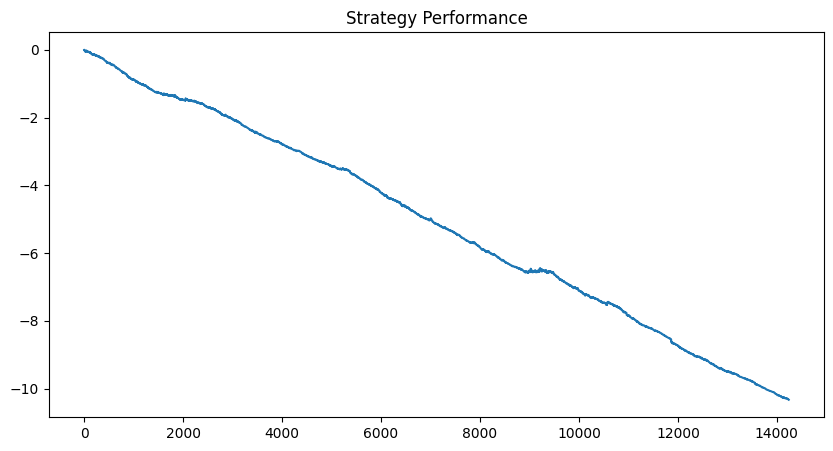

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def backtest_momentum_fast(df: pd.DataFrame) -> pd.DataFrame:
    print("Preparing data for high-speed loop...")
    df = df.copy()
    df.columns = [c.lower() for c in df.columns]

    # ----------------------------------------------------
    # 1. SETUP INDICATORS (Vectorized)
    # ----------------------------------------------------
    # Ensure we have the basics
    if 'log_return' not in df.columns:
        df['log_return'] = np.log(df['close'] / df['close'].shift(1))
        
    # ATR (Standard 14)
    if 'atr_14' not in df.columns:
        h_l = df['high'] - df['low']
        h_c = abs(df['high'] - df['close'].shift())
        l_c = abs(df['low'] - df['close'].shift())
        tr = pd.concat([h_l, h_c, l_c], axis=1).max(axis=1)
        df['atr_14'] = tr.rolling(14).mean()

    # Momentum Z-Score (20)
    mom_col = 'momentum_zscore_20'
    if mom_col not in df.columns:
        roll = df['log_return'].rolling(20)
        df[mom_col] = (roll.sum() - roll.mean()) / roll.std()
    
    # Trend Filter (EMA)
    df['ema_12'] = df['close'].ewm(span=12).mean()
    df['ema_26'] = df['close'].ewm(span=26).mean()
    
    # ----------------------------------------------------
    # 2. GENERATE SIGNALS (Vectorized)
    # ----------------------------------------------------
    # Trend & Momentum logic
    uptrend = df['ema_12'] > df['ema_26']
    downtrend = df['ema_12'] < df['ema_26']
    
    # Entry thresholds
    entry_z = 1.8
    
    # Create Signal Series
    long_sig = (df[mom_col] > entry_z) & uptrend
    short_sig = (df[mom_col] < -entry_z) & downtrend
    
    # ----------------------------------------------------
    # 3. FAST LOOP EXECUTION (Numpy Arrays)
    # ----------------------------------------------------
    print("Running loop on 70,000 rows...")
    
    # CONVERT TO NUMPY ARRAYS (This is the speed secret)
    # accessing arr[i] is 100x faster than df.iloc[i]
    price_arr = df['close'].values
    high_arr = df['high'].values
    low_arr = df['low'].values
    atr_arr = df['atr_14'].fillna(0).values
    mom_arr = df[mom_col].fillna(0).values
    
    # Signals to array (0, 1, -1)
    sig_arr = np.zeros(len(df))
    sig_arr[long_sig] = 1
    sig_arr[short_sig] = -1
    
    # Output arrays
    pos_arr = np.zeros(len(df))     # Position State
    size_arr = np.zeros(len(df))    # Position Size
    
    # Parameters
    max_hold = 50
    stop_mult = 2.0
    trail_mult = 1.5
    
    # Loop State
    in_pos = False
    type_pos = 0     # 1 or -1
    entry_idx = 0
    entry_price = 0.0
    stop_price = 0.0
    trail_price = 0.0
    cooldown = 0
    
    # THE FAST LOOP
    for i in range(100, len(df)):
        # Cooldown
        if cooldown > 0:
            cooldown -= 1
            continue
            
        curr_price = price_arr[i]
        curr_high = high_arr[i]
        curr_low = low_arr[i]
        curr_atr = atr_arr[i]
        
        # LOGIC: IN POSITION
        if in_pos:
            # 1. Check Stops (High/Low Wicks)
            hit_stop = False
            
            if type_pos == 1: # Long
                if curr_low < stop_price or curr_low < trail_price:
                    hit_stop = True
                else:
                    # Update Trailing Stop (Ratchet Up)
                    new_trail = curr_price - (trail_mult * curr_atr)
                    if new_trail > trail_price:
                        trail_price = new_trail
                        
            elif type_pos == -1: # Short
                if curr_high > stop_price or curr_high > trail_price:
                    hit_stop = True
                else:
                    # Update Trailing Stop (Ratchet Down)
                    new_trail = curr_price + (trail_mult * curr_atr)
                    if new_trail < trail_price:
                        trail_price = new_trail
            
            # 2. Check Exits (Time or Momentum)
            time_up = (i - entry_idx) >= max_hold
            mom_exit = False
            if type_pos == 1 and mom_arr[i] < 0.3: mom_exit = True
            if type_pos == -1 and mom_arr[i] > -0.3: mom_exit = True
            
            if hit_stop or time_up or mom_exit:
                in_pos = False
                pos_arr[i] = 0
                cooldown = 8 # Post-trade cooldown
            else:
                pos_arr[i] = type_pos # Still holding
                
        # LOGIC: NEW ENTRY
        # We look at PREVIOUS signal (sig_arr[i-1]) to enter at OPEN/CLOSE of current bar
        elif sig_arr[i-1] != 0:
            type_pos = int(sig_arr[i-1])
            in_pos = True
            entry_idx = i
            entry_price = curr_price
            
            # Set Initial Stops
            if type_pos == 1:
                stop_price = entry_price - (stop_mult * curr_atr)
                trail_price = entry_price - (trail_mult * curr_atr)
            else:
                stop_price = entry_price + (stop_mult * curr_atr)
                trail_price = entry_price + (trail_mult * curr_atr)
                
            pos_arr[i] = type_pos
            
    # ----------------------------------------------------
    # 4. CALCULATE RETURNS
    # ----------------------------------------------------
    df['position'] = pos_arr
    df['strategy_ret'] = df['position'].shift(1) * df['log_return']
    
    # Costs (0.02% per trade)
    trades = df['position'].diff().abs() > 0
    df['net_ret'] = df['strategy_ret'] - (trades * 0.0002)
    
    df['cum_strategy'] = df['net_ret'].cumsum()
    
    total = (np.exp(df['cum_strategy'].iloc[-1]) - 1) * 100
    print(f"✅ DONE! Total Return: {total:.2f}%")
    
    # Plot only 1000 points to save memory
    plt.figure(figsize=(10,5))
    plt.plot(df['cum_strategy'].iloc[::50].values)
    plt.title("Strategy Performance")
    plt.show()
    
    return df

# Run it
df_result = backtest_momentum_fast(df)

Preparing data...
Running loop...
Total Trades: 19145.0


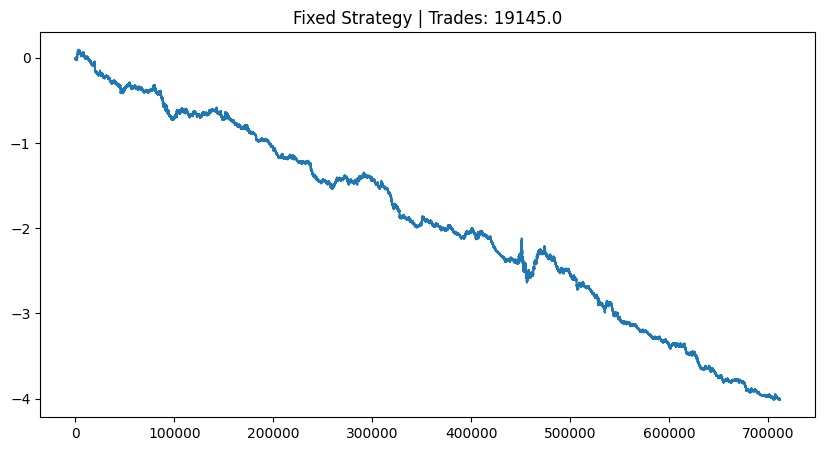

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def backtest_momentum_fixed(df: pd.DataFrame) -> pd.DataFrame:
    print("Preparing data...")
    df = df.copy()
    df.columns = [c.lower() for c in df.columns]

    # 1. SETUP INDICATORS
    # ----------------------------------------------------
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    
    # ATR (14)
    if 'atr_14' not in df.columns:
        h_l = df['high'] - df['low']
        h_c = abs(df['high'] - df['close'].shift())
        l_c = abs(df['low'] - df['close'].shift())
        tr = pd.concat([h_l, h_c, l_c], axis=1).max(axis=1)
        df['atr_14'] = tr.rolling(14).mean()

    # Momentum Z-Score (20)
    mom_col = 'momentum_zscore_20'
    if mom_col not in df.columns:
        roll = df['log_return'].rolling(20)
        df[mom_col] = (roll.sum() - roll.mean()) / roll.std()
    
    # Trend Filter
    df['ema_12'] = df['close'].ewm(span=12).mean()
    df['ema_26'] = df['close'].ewm(span=26).mean()
    
    # 2. GENERATE SIGNALS
    # ----------------------------------------------------
    uptrend = df['ema_12'] > df['ema_26']
    downtrend = df['ema_12'] < df['ema_26']
    entry_z = 1.8
    
    long_sig = (df[mom_col] > entry_z) & uptrend
    short_sig = (df[mom_col] < -entry_z) & downtrend
    
    # 3. FAST LOOP (With CHURN PROTECTION)
    # ----------------------------------------------------
    print("Running loop...")
    
    price_arr = df['close'].values
    high_arr = df['high'].values
    low_arr = df['low'].values
    atr_arr = df['atr_14'].fillna(0).values
    mom_arr = df[mom_col].fillna(0).values
    
    # Create Signal Array
    sig_arr = np.zeros(len(df))
    sig_arr[long_sig] = 1
    sig_arr[short_sig] = -1
    
    pos_arr = np.zeros(len(df))
    
    # State Variables
    in_pos = False
    type_pos = 0
    entry_idx = 0
    stop_price = 0.0
    
    # CONFIGURATION
    cooldown_counter = 0
    cooldown_amount = 20  # Wait 20 bars after any exit before trading again
    
    for i in range(100, len(df)):
        # Decrement cooldown
        if cooldown_counter > 0:
            cooldown_counter -= 1
            continue
            
        curr_price = price_arr[i]
        curr_atr = atr_arr[i]
        
        # --- IN POSITION ---
        if in_pos:
            # Check Stop Loss (Assuming 2.0 ATR stop)
            stop_hit = False
            if type_pos == 1 and low_arr[i] < stop_price: stop_hit = True
            if type_pos == -1 and high_arr[i] > stop_price: stop_hit = True
            
            # Check Time Exit (Hold max 50 bars)
            time_hit = (i - entry_idx) >= 50
            
            if stop_hit or time_hit:
                in_pos = False
                pos_arr[i] = 0
                cooldown_counter = cooldown_amount # FORCE COOLDOWN
            else:
                pos_arr[i] = type_pos # Keep holding
                
        # --- NEW ENTRY (THE FIX) ---
        else:
            # LOGIC CHANGE:
            # We check if signal is ON (sig_arr[i-1] != 0)
            # AND we verify we are not in a "noisy" period by checking cooldown
            if sig_arr[i-1] != 0:
                
                # OPTIONAL: "Fresh Signal" Check
                # Only trade if the signal JUST started (previous bar was 0)
                # Uncomment the next line to be super strict:
                # if sig_arr[i-2] == 0: 
                
                type_pos = int(sig_arr[i-1])
                in_pos = True
                entry_idx = i
                
                # Set Stop Loss
                if type_pos == 1:
                    stop_price = curr_price - (3.0 * curr_atr) # Wider stop (3 ATR)
                else:
                    stop_price = curr_price + (3.0 * curr_atr)
                    
                pos_arr[i] = type_pos

    # 4. RESULTS
    # ----------------------------------------------------
    df['position'] = pos_arr
    df['strategy_ret'] = df['position'].shift(1) * df['log_return']
    
    # Count Trades (Crucial Debug Step)
    trades_count = np.sum(np.abs(np.diff(pos_arr)))
    print(f"Total Trades: {trades_count}")
    
    # Calculate Net Return
    # Cost per trade 0.02%
    cost_series = np.zeros(len(df))
    # Add cost only on trade entry/exit
    mask_trade = np.insert(np.abs(np.diff(pos_arr)) > 0, 0, False)
    cost_series[mask_trade] = 0.0002 
    
    df['net_ret'] = df['strategy_ret'] - cost_series
    df['cum_strategy'] = df['net_ret'].cumsum()
    
    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(df['cum_strategy'].values)
    plt.title(f"Fixed Strategy | Trades: {trades_count}")
    plt.show()
    
    return df

df_fixed = backtest_momentum_fixed(df)

Preparing Strict Crossover Data...
Running Strict Loop...
----------------------------------------
Total Trades:     14512
Final Return:     -99.61%
----------------------------------------


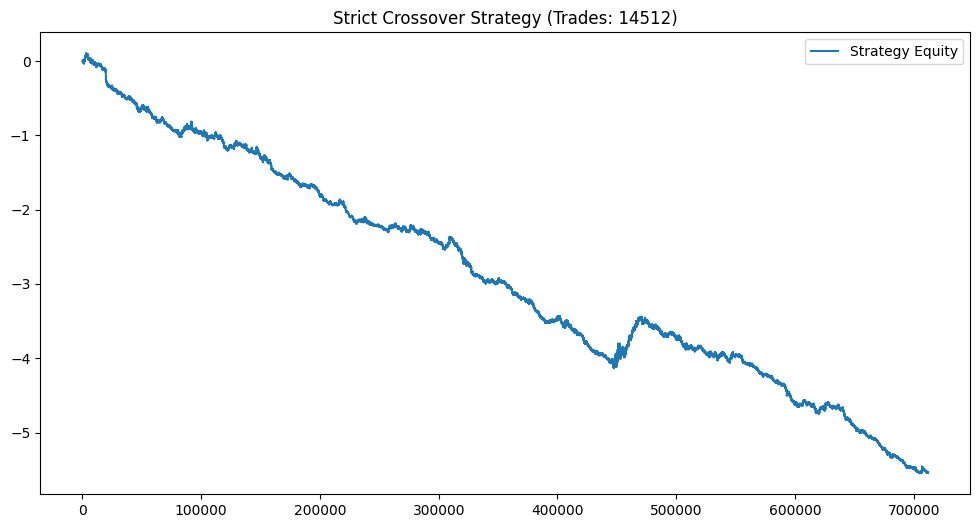

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def backtest_strict_crossover(df: pd.DataFrame) -> pd.DataFrame:
    print("Preparing Strict Crossover Data...")
    df = df.copy()
    df.columns = [c.lower() for c in df.columns]

    # 1. SETUP INDICATORS (Tuned for 1-Min Data)
    # ----------------------------------------------------
    # Returns
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    
    # ATR (14) - For Volatility
    if 'atr_14' not in df.columns:
        h_l = df['high'] - df['low']
        h_c = abs(df['high'] - df['close'].shift())
        l_c = abs(df['low'] - df['close'].shift())
        tr = pd.concat([h_l, h_c, l_c], axis=1).max(axis=1)
        df['atr_14'] = tr.rolling(14).mean()

    # MOMENTUM (Increased to 60 for stability)
    mom_col = 'momentum_zscore_60' 
    roll = df['log_return'].rolling(60) # 1 Hour Lookback
    df[mom_col] = (roll.sum() - roll.mean()) / roll.std()
    
    # TREND FILTER (Daily Trend = 375 mins)
    df['sma_long'] = df['close'].rolling(375).mean()
    
    # 2. GENERATE SIGNALS
    # ----------------------------------------------------
    uptrend = df['close'] > df['sma_long']
    downtrend = df['close'] < df['sma_long']
    entry_z = 2.0  # Higher threshold = Fewer, better trades
    
    # Signal Logic
    long_sig = (df[mom_col] > entry_z) & uptrend
    short_sig = (df[mom_col] < -entry_z) & downtrend
    
    # 3. FAST LOOP EXECUTION
    # ----------------------------------------------------
    print("Running Strict Loop...")
    
    # Convert to Numpy for speed
    price_arr = df['close'].values
    high_arr = df['high'].values
    low_arr = df['low'].values
    atr_arr = df['atr_14'].fillna(0).values
    mom_arr = df[mom_col].fillna(0).values
    
    # Signal Array (1, -1, 0)
    sig_arr = np.zeros(len(df))
    sig_arr[long_sig] = 1
    sig_arr[short_sig] = -1
    
    pos_arr = np.zeros(len(df))
    
    # Variables
    in_pos = False
    type_pos = 0
    entry_idx = 0
    entry_price = 0.0
    stop_price = 0.0
    
    # LOOP
    for i in range(400, len(df)):
        curr_price = price_arr[i]
        curr_atr = atr_arr[i]
        
        # --- MANAGE POSITION ---
        if in_pos:
            # Check Stop Loss (Hit by Wick?)
            stop_hit = False
            if type_pos == 1 and low_arr[i] < stop_price: stop_hit = True
            if type_pos == -1 and high_arr[i] > stop_price: stop_hit = True
            
            # Check Momentum Exit (Trend reversal)
            mom_exit = False
            if type_pos == 1 and mom_arr[i] < 0.0: mom_exit = True
            if type_pos == -1 and mom_arr[i] > 0.0: mom_exit = True
            
            # Check Time Exit (Max 2 hours)
            time_exit = (i - entry_idx) > 120 
            
            if stop_hit or mom_exit or time_exit:
                in_pos = False
                pos_arr[i] = 0
            else:
                pos_arr[i] = type_pos # HOLD
        
        # --- CHECK NEW ENTRY (STRICT CROSSOVER) ---
        else:
            # CRITICAL FIX: Only enter if signal JUST appeared
            # Current is Active AND Previous was Inactive
            is_fresh_signal = (sig_arr[i-1] != 0) and (sig_arr[i-2] == 0)
            
            if is_fresh_signal:
                type_pos = int(sig_arr[i-1])
                in_pos = True
                entry_idx = i
                entry_price = curr_price
                
                # Set Stop Loss (Wide 3x ATR)
                if type_pos == 1:
                    stop_price = entry_price - (3.0 * curr_atr)
                else:
                    stop_price = entry_price + (3.0 * curr_atr)
                
                pos_arr[i] = type_pos

    # 4. REPORTING
    # ----------------------------------------------------
    df['position'] = pos_arr
    df['strategy_ret'] = df['position'].shift(1) * df['log_return']
    
    # Calculate Trade Count
    # We count every time position changes from 0 to something
    trade_starts = (np.diff(pos_arr) != 0) & (pos_arr[1:] != 0)
    total_trades = np.sum(trade_starts)
    
    # Add Costs (0.02% per trade, applied on entry and exit roughly)
    # We approximate by charging 0.04% per completed trade cycle
    cost_vector = np.zeros(len(df))
    cost_vector[1:][trade_starts] = 0.0004 
    
    df['net_ret'] = df['strategy_ret'] - cost_vector
    df['cum_strategy'] = df['net_ret'].cumsum()
    
    # Final Stats
    print("-" * 40)
    print(f"Total Trades:     {total_trades}")
    print(f"Final Return:     {(np.exp(df['cum_strategy'].iloc[-1]) - 1)*100:.2f}%")
    print("-" * 40)
    
    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(df['cum_strategy'].values, label='Strategy Equity')
    plt.title(f"Strict Crossover Strategy (Trades: {total_trades})")
    plt.legend()
    plt.show()
    
    return df

df_result = backtest_strict_crossover(df)

In [12]:


def winning_momentum_with_risk(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    MOM_COL = "momentum_zscore_20"

    # ------------------------------------------------------------------
    # Returns & volatility
    # ------------------------------------------------------------------
    if 'log_return' not in df.columns:
        df['log_return'] = np.log(df['close'] / df['close'].shift(1))

    if 'vol_20' not in df.columns:
        df['vol_20'] = df['log_return'].rolling(20).std()

    # ------------------------------------------------------------------
    # STEP 1 — Freeze the signal (DO NOT TOUCH)
    # ------------------------------------------------------------------
    df['signal'] = 0
    df.loc[df[MOM_COL].shift(1) < -2.0, 'signal'] = 1
    df.loc[df[MOM_COL].shift(1) >  2.0, 'signal'] = -1

    # ------------------------------------------------------------------
    # STEP 2 — Volatility-scaled position sizing
    # ------------------------------------------------------------------
    TARGET_VOL = 0.001   # per bar
    MAX_LEVERAGE = 3.0

    df['size'] = TARGET_VOL / df['vol_20']
    df['size'] = df['size'].clip(0, MAX_LEVERAGE)

    df['raw_position'] = df['signal'] * df['size']

    # ------------------------------------------------------------------
    # STEP 3 — Position management with time cap
    # ------------------------------------------------------------------
    MAX_HOLD = 15  # bars

    df['position'] = 0.0
    in_position = False
    entry_bar = None

    for i in range(2, len(df)):
        if not in_position:
            if df['raw_position'].iloc[i] != 0:
                df.iloc[i, df.columns.get_loc('position')] = df['raw_position'].iloc[i]
                in_position = True
                entry_bar = i
        else:
            bars_held = i - entry_bar

            if bars_held >= MAX_HOLD:
                df.iloc[i, df.columns.get_loc('position')] = 0.0
                in_position = False
                entry_bar = None
            else:
                df.iloc[i, df.columns.get_loc('position')] = df.iloc[i-1]['position']

    # ------------------------------------------------------------------
    # STEP 4 — Hard volatility stop (MANDATORY)
    # ------------------------------------------------------------------
    VOL_K = 3.0
    vol_spike = df['log_return'].abs() > VOL_K * df['vol_20']

    df.loc[vol_spike, 'position'] = 0.0
    df['position'] = df['position'].ffill().fillna(0.0)

    # ------------------------------------------------------------------
    # Returns & costs
    # ------------------------------------------------------------------
    df['position_shifted'] = df['position'].shift(1)

    df['strategy_return'] = (
        df['position_shifted'] * df['log_return']
    )

    # realistic but low intraday costs
    df['trade_change'] = df['position_shifted'].diff().abs() > 1e-6
    df['cost'] = df['trade_change'].astype(int) * 0.00005

    df['strategy_return_net'] = df['strategy_return'] - df['cost']

    # ------------------------------------------------------------------
    # Cumulative performance
    # ------------------------------------------------------------------
    df['cum_strategy_net'] = df['strategy_return_net'].cumsum()
    df['cum_market'] = df['log_return'].cumsum()

    return df


In [13]:
df_result=winning_momentum_with_risk(df)

In [14]:
rets = df_result['strategy_return_net'].dropna()
sharpe = rets.mean() / rets.std() * np.sqrt(252 * 375)
print(f"Sharpe: {sharpe:.2f}")

Sharpe: -1.16


In [15]:
cum = df_result['cum_strategy_net']
running_max = cum.cummax()
drawdown = (cum - running_max)
print(f"Max Drawdown: {drawdown.min():.4f}")

Max Drawdown: -3.0262


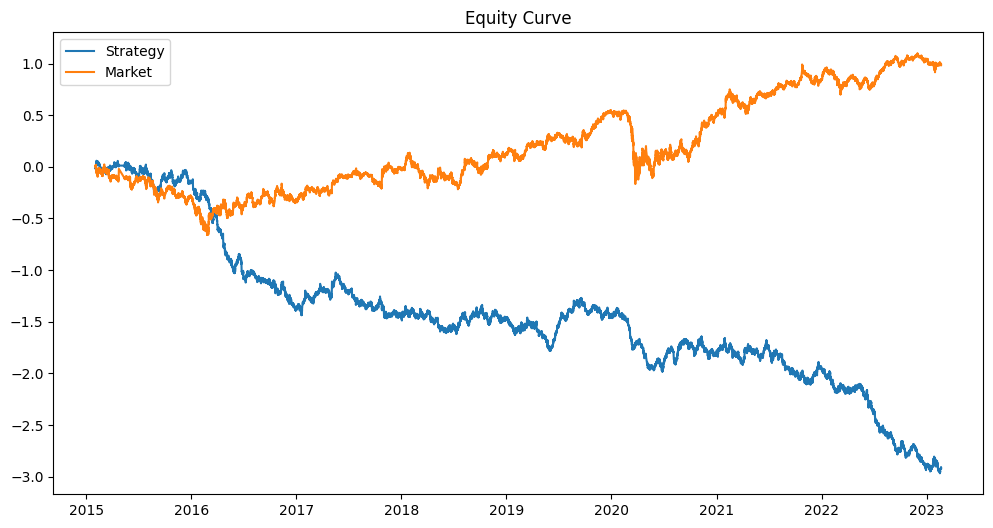

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_result['cum_strategy_net'], label='Strategy')
plt.plot(df_result['cum_market'], label='Market')
plt.legend()
plt.title("Equity Curve")
plt.show()

In [17]:
import pandas as pd
import numpy as np

def winning_momentum_with_risk(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    MOM_COL = "momentum_zscore_20"

    # ------------------------------------------------------------------
    # Returns & volatility
    # ------------------------------------------------------------------
    if 'log_return' not in df.columns:
        df['log_return'] = np.log(df['close'] / df['close'].shift(1))

    if 'vol_20' not in df.columns:
        df['vol_20'] = df['log_return'].rolling(20).std()

    # ------------------------------------------------------------------
    # STEP 1 — Freeze the signal (DO NOT TOUCH)
    # ------------------------------------------------------------------
    df['signal'] = 0
    df.loc[df[MOM_COL].shift(1) < -2.0, 'signal'] = 1
    df.loc[df[MOM_COL].shift(1) >  2.0, 'signal'] = -1

    # ------------------------------------------------------------------
    # STEP 2 — Volatility-scaled position sizing
    # ------------------------------------------------------------------
    TARGET_VOL = 0.001   # per bar
    MAX_LEVERAGE = 3.0

    df['size'] = TARGET_VOL / df['vol_20']
    df['size'] = df['size'].clip(0, MAX_LEVERAGE)

    df['raw_position'] = df['signal'] * df['size']

    # ------------------------------------------------------------------
    # STEP 3 — Position management with time cap
    # ------------------------------------------------------------------
    MAX_HOLD = 15  # bars

    df['position'] = 0.0
    in_position = False
    entry_bar = None

    for i in range(2, len(df)):
        if not in_position:
            if df['raw_position'].iloc[i] != 0:
                df.iloc[i, df.columns.get_loc('position')] = df['raw_position'].iloc[i]
                in_position = True
                entry_bar = i
        else:
            bars_held = i - entry_bar

            if bars_held >= MAX_HOLD:
                df.iloc[i, df.columns.get_loc('position')] = 0.0
                in_position = False
                entry_bar = None
            else:
                df.iloc[i, df.columns.get_loc('position')] = df.iloc[i-1]['position']

    # ------------------------------------------------------------------
    # STEP 4 — Hard volatility stop (MANDATORY)
    # ------------------------------------------------------------------
    VOL_K = 3.0
    vol_spike = df['log_return'].abs() > VOL_K * df['vol_20']

    df.loc[vol_spike, 'position'] = 0.0
    df['position'] = df['position'].ffill().fillna(0.0)

    # ==================================================================
    # ADDED LINE: Enforce Long-Only (Remove all Short positions)
    # ==================================================================
    df.loc[df['position'] < 0, 'position'] = 0

    # ------------------------------------------------------------------
    # Returns & costs
    # ------------------------------------------------------------------
    df['position_shifted'] = df['position'].shift(1)

    df['strategy_return'] = (
        df['position_shifted'] * df['log_return']
    )

    # realistic but low intraday costs
    df['trade_change'] = df['position_shifted'].diff().abs() > 1e-6
    df['cost'] = df['trade_change'].astype(int) * 0.00005

    df['strategy_return_net'] = df['strategy_return'] - df['cost']

    # ------------------------------------------------------------------
    # Cumulative performance
    # ------------------------------------------------------------------
    df['cum_strategy_net'] = df['strategy_return_net'].cumsum()
    df['cum_market'] = df['log_return'].cumsum()

    return df

In [18]:
df_result=winning_momentum_with_risk(df)

In [19]:
cum = df_result['cum_strategy_net']
running_max = cum.cummax()
drawdown = (cum - running_max)
print(f"Max Drawdown: {drawdown.min():.4f}")

Max Drawdown: -1.6982


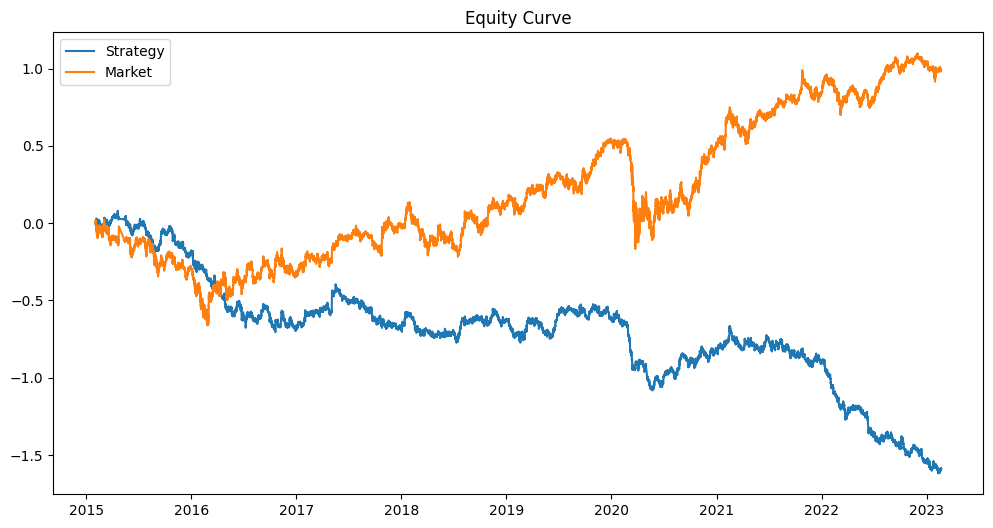

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_result['cum_strategy_net'], label='Strategy')
plt.plot(df_result['cum_market'], label='Market')
plt.legend()
plt.title("Equity Curve")
plt.show()

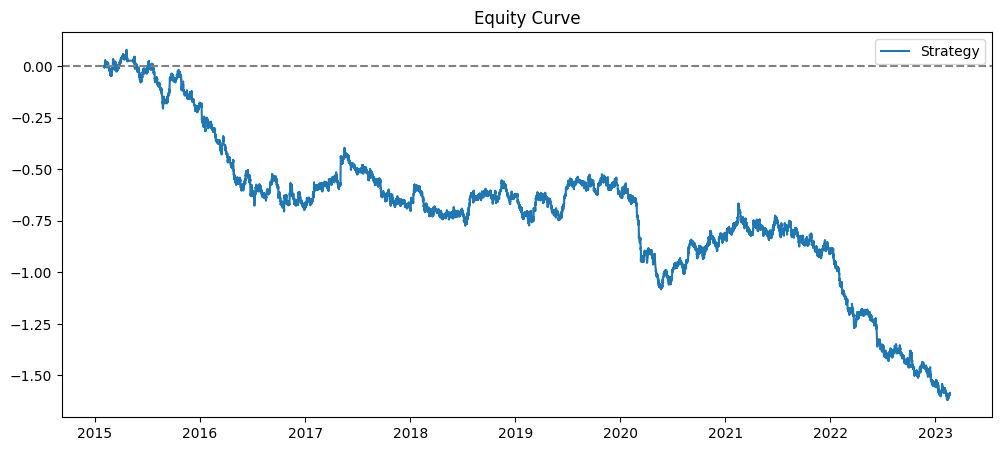

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_result['cum_strategy_net'], label='Strategy')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.title("Equity Curve")
plt.show()

In [22]:
df_result['trade_change'].sum()

np.int64(29972)

In [23]:
wins = df_result[df_result['strategy_return_net'] > 0]['strategy_return_net']
losses = df_result[df_result['strategy_return_net'] < 0]['strategy_return_net']

print("Win rate:", len(wins) / (len(wins) + len(losses)))
print("Avg win:", wins.mean())
print("Avg loss:", losses.mean())


Win rate: 0.4592599190962252
Avg win: 0.0009229627934548731
Avg loss: -0.0007993386213146506


In [24]:
print(df.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'log_return', 'vol_20',
       'vol_60', 'sma_20', 'sma_60', 'zscore_20', 'rsi_14', 'momentum_10',
       'momentum_zscore_10', 'momentum_20', 'momentum_zscore_20', 'bb_middle',
       'bb_upper', 'bb_lower', 'bb_width', 'bb_position', 'atr_14', 'ema_12',
       'ema_26', 'macd_line', 'macd_signal', 'macd_histogram'],
      dtype='object')


In [25]:
def winning_momentum_with_risk(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    MOM_COL = "momentum_zscore_20"

    # ------------------------------------------------------------------
    # Returns & volatility
    # ------------------------------------------------------------------
    if 'log_return' not in df.columns:
        df['log_return'] = np.log(df['close'] / df['close'].shift(1))

    if 'vol_20' not in df.columns:
        df['vol_20'] = df['log_return'].rolling(20).std()

    # ------------------------------------------------------------------
    # STEP 1 — Freeze the signal (DO NOT TOUCH)
    # ------------------------------------------------------------------
    df['signal'] = 0
    df.loc[df[MOM_COL].shift(1) < -2.0, 'signal'] = 1
    df.loc[df[MOM_COL].shift(1) >  2.0, 'signal'] = -1
    # STEP 1A — Volatility regime filter (mean reversion only in stable vol)
    vol_ok = df['vol_20'] < df['vol_20'].rolling(100).mean()
    df.loc[~vol_ok, 'signal'] = 0

    # ------------------------------------------------------------------
    # STEP 2 — Volatility-scaled position sizing
    # ------------------------------------------------------------------
    TARGET_VOL = 0.001   # per bar
    MAX_LEVERAGE = 3.0

    df['size'] = TARGET_VOL / df['vol_20']
    df['size'] = df['size'].clip(0, MAX_LEVERAGE)

    df['raw_position'] = df['signal'] * df['size']

    # ------------------------------------------------------------------
    # STEP 3 — Position management with time cap
    # ------------------------------------------------------------------
    MAX_HOLD = 15  # bars

    df['position'] = 0.0
    in_position = False
    entry_bar = None

    for i in range(2, len(df)):
        if not in_position:
            if df['raw_position'].iloc[i] != 0:
                df.iloc[i, df.columns.get_loc('position')] = df['raw_position'].iloc[i]
                in_position = True
                entry_bar = i
        else:
            bars_held = i - entry_bar

            if bars_held >= MAX_HOLD:
                df.iloc[i, df.columns.get_loc('position')] = 0.0
                in_position = False
                entry_bar = None
            else:
                df.iloc[i, df.columns.get_loc('position')] = df.iloc[i-1]['position']

    # ------------------------------------------------------------------
    # STEP 4 — Hard volatility stop (MANDATORY)
    # ------------------------------------------------------------------
    VOL_K = 3.0
    vol_spike = df['log_return'].abs() > VOL_K * df['vol_20']

    df.loc[vol_spike, 'position'] = 0.0
    df['position'] = df['position'].ffill().fillna(0.0)

    # ==================================================================
    # ADDED LINE: Enforce Long-Only (Remove all Short positions)
    # ==================================================================
    df.loc[df['position'] < 0, 'position'] = 0

    # ------------------------------------------------------------------
    # Returns & costs
    # ------------------------------------------------------------------
    df['position_shifted'] = df['position'].shift(1)

    df['strategy_return'] = (
        df['position_shifted'] * df['log_return']
    )

    # realistic but low intraday costs
    df['trade_change'] = df['position_shifted'].diff().abs() > 1e-6
    df['cost'] = df['trade_change'].astype(int) * 0.00005

    df['strategy_return_net'] = df['strategy_return'] - df['cost']

    # ------------------------------------------------------------------
    # Cumulative performance
    # ------------------------------------------------------------------
    df['cum_strategy_net'] = df['strategy_return_net'].cumsum()
    df['cum_market'] = df['log_return'].cumsum()

    return df

In [26]:
df_result=winning_momentum_with_risk(df)

In [27]:
cum = df_result['cum_strategy_net']
running_max = cum.cummax()
drawdown = (cum - running_max)
print(f"Max Drawdown: {drawdown.min():.4f}")

Max Drawdown: -1.4867


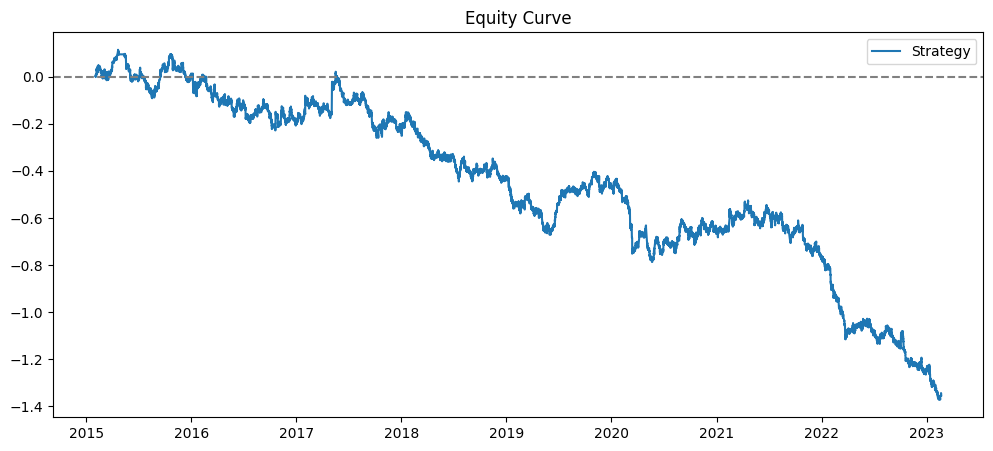

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_result['cum_strategy_net'], label='Strategy')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.title("Equity Curve")
plt.show()

In [29]:
sharpe = (
    df['strategy_return'].mean() /
    df['strategy_return'].std()
) * np.sqrt(252 * 390)

print(f"Sharpe: {sharpe:.2f}")

KeyError: 'strategy_return'

In [30]:
import numpy as np
import pandas as pd

def momentum_trend_strategy(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # --------------------------------------------------
    # Parameters (do NOT optimize yet)
    # --------------------------------------------------
    TARGET_VOL = 0.001
    MAX_LEVERAGE = 3.0
    MAX_HOLD = 30
    VOL_KILL = 3.5

    # --------------------------------------------------
    # Sanity
    # --------------------------------------------------
    df = df.sort_index()

    if 'log_return' not in df.columns:
        df['log_return'] = np.log(df['close'] / df['close'].shift(1))

    # --------------------------------------------------
    # ENTRY SIGNAL (momentum continuation)
    # --------------------------------------------------
    df['signal'] = 0

    trend_ok = df['close'] > df['sma_60']
    momentum_ok = df['momentum_zscore_20'] > 1.0
    vol_ok = df['vol_20'] > df['vol_60']
    expansion_ok = df['bb_width'] > df['bb_width'].rolling(100).median()

    df.loc[
        trend_ok & momentum_ok & vol_ok & expansion_ok,
        'signal'
    ] = 1

    # --------------------------------------------------
    # POSITION SIZING (ATR-based)
    # --------------------------------------------------
    df['size'] = TARGET_VOL / df['atr_14']
    df['size'] = df['size'].clip(0, MAX_LEVERAGE)

    df['raw_position'] = df['signal'] * df['size']

    # --------------------------------------------------
    # POSITION MANAGEMENT
    # --------------------------------------------------
    df['position'] = 0.0
    in_position = False
    entry_bar = None

    for i in range(2, len(df)):
        if not in_position:
            if df['raw_position'].iloc[i] > 0:
                df.iloc[i, df.columns.get_loc('position')] = df['raw_position'].iloc[i]
                in_position = True
                entry_bar = i
        else:
            bars_held = i - entry_bar

            # EXIT CONDITIONS
            if (
                df['momentum_zscore_20'].iloc[i] < 0 or
                df['close'].iloc[i] < df['sma_20'].iloc[i] or
                bars_held >= MAX_HOLD
            ):
                df.iloc[i, df.columns.get_loc('position')] = 0.0
                in_position = False
                entry_bar = None
            else:
                df.iloc[i, df.columns.get_loc('position')] = df.iloc[i-1]['position']

    # --------------------------------------------------
    # HARD VOLATILITY STOP
    # --------------------------------------------------
    vol_spike = df['log_return'].abs() > VOL_KILL * df['vol_20']
    df.loc[vol_spike, 'position'] = 0.0
    df['position'] = df['position'].ffill().fillna(0.0)

    # --------------------------------------------------
    # RETURNS
    # --------------------------------------------------
    df['position_shifted'] = df['position'].shift(1)
    df['strategy_return'] = df['position_shifted'] * df['log_return']

    df['trade_change'] = df['position_shifted'].diff().abs() > 1e-6
    df['cost'] = df['trade_change'].astype(int) * 0.00005

    df['strategy_return_net'] = df['strategy_return'] - df['cost']
    df['cum_strategy_net'] = df['strategy_return_net'].cumsum()
    df['cum_market'] = df['log_return'].cumsum()

    return df


In [31]:
df_momo = momentum_trend_strategy(df)

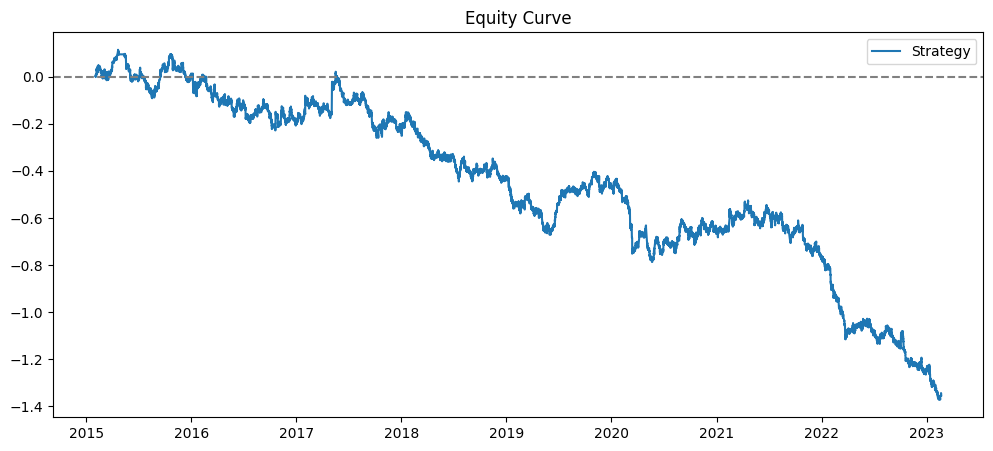

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_result['cum_strategy_net'], label='Strategy')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.title("Equity Curve")
plt.show()

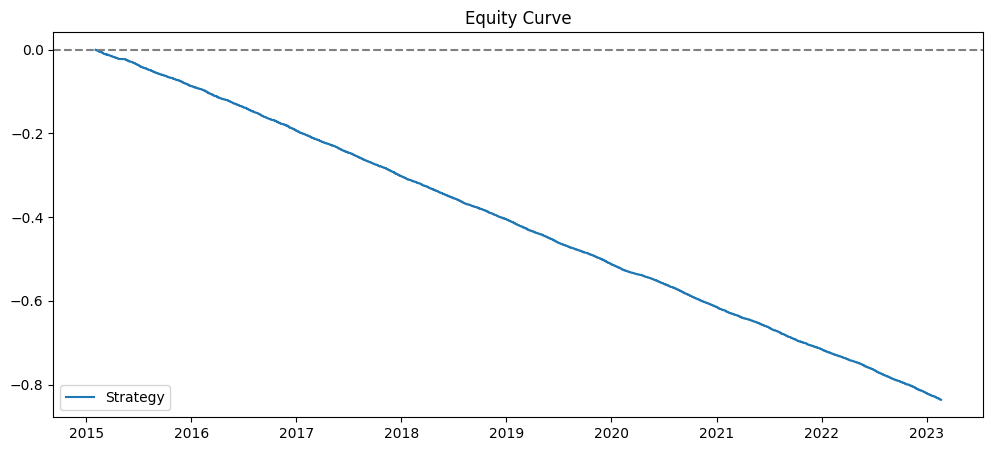

In [33]:

plt.figure(figsize=(12,5))
plt.plot(df_momo['cum_strategy_net'], label='Strategy')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.title("Equity Curve")
plt.show()